In [1]:
import json
import os
import math


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import pickle
from collections import defaultdict
from itertools import groupby
from scipy import stats

import seaborn as sns
from tqdm import tqdm
#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower


HOME="/linkhome/rech/genini01/ucv88ce/"
#10 ms per cluster unit

In [2]:
def get_phone_ali(ali_ctm, lang):
    phone_ali = pd.read_csv(ali_ctm, sep=" ", header=None)
    phone_ali.columns=["wav", "num", "onset", "dur_s", "phone_long", "None"]
    phone_ali["phone"] = phone_ali["phone_long"].apply(lambda x: x.split("_")[0])
    phone_ali["dur_ms"] = phone_ali["dur_s"].apply(lambda x: x*1000)
    phone_ali['wav'] = phone_ali['wav'].apply(lambda x: x.split('-')[1])


    if lang=="fr":
        phone_ali['phone'] = phone_ali['phone'].replace("au", "oo")
    return phone_ali

def sum_pool(row, w2feats):
    onset = math.ceil(row["onset"]*100)
    offset = math.ceil(row["onset"]*100+(row["dur_ms"]/10))
    cpc_feats_mat = w2feats[row["wav"]][onset:offset]
    return np.sum(cpc_feats_mat, axis=0)

def max_pool(row, w2feats):
    onset = math.ceil(row["onset"]*100)
    offset = math.ceil(row["onset"]*100+(row["dur_ms"]/10))
    cpc_feats_mat = w2feats[row["wav"]][onset:offset]
    return np.max(cpc_feats_mat, axis=0)

def avg_pool(row, w2feats):
    onset = math.ceil(row["onset"]*100)
    offset = math.ceil(row["onset"]*100+(row["dur_ms"]/10))
    cpc_feats_mat = w2feats[row["wav"]][onset:offset]
    return np.mean(cpc_feats_mat, axis=0)

def get_full_ali(w2feats, phone_ali, lang):
    phone_ali = phone_ali[phone_ali['phone']!="SIL"]
    phone_ali = phone_ali[phone_ali['wav'].isin(w2feats.keys())] 
    phone_ali['lang'] = lang
    phone_ali['max_pool'] = phone_ali.apply(max_pool, args=(w2feats,), axis = 1)
    phone_ali['sum_pool'] = phone_ali.apply(sum_pool, args=(w2feats,), axis = 1)
    phone_ali['avg_pool'] = phone_ali.apply(avg_pool, args=(w2feats,), axis = 1)
    return phone_ali

In [3]:
def get_w2feat(lang, root_path = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/3200h/00/features/cpc_small/'):
    
    
    if not os.path.isfile(os.path.join(root_path, 'CV_{}'.format(lang),'w2feat.pkl')):
        w2feat = {} 
        cv_txt = [x for x in os.listdir(os.path.join(root_path, 'CV_{}'.format(lang)))]

        for wav in tqdm(cv_txt):
            with open(os.path.join(root_path, 'CV_{}'.format(lang), wav)) as infile:
                #w2feat[wav.split('.')[0]] = np.array([np.array(x.strip("\n{}'").split(' ')).astype(np.float) for x in infile]).astype(np.float)
                try:
                    w2feat[wav.split('.')[0]] = np.loadtxt(infile)
                except:
                    print(wav)
        print("Saving to pickle")
        with open(os.path.join(root_path, 'CV_{}'.format(lang),'w2feat.pkl'), 'wb') as handle:
            pickle.dump(w2feat, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(root_path, 'CV_{}'.format(lang),'w2feat.pkl'), 'rb') as handle:
            w2feat = pickle.load(handle)
    return w2feat



def retrieve_alignment(ali_ctm, lang, root_path = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/3200h/00/features/cpc_small/'):
    
    if os.path.isfile(os.path.join(root_path, 'CV_{}'.format(lang),'full_alignment.pkl')):
        with open(os.path.join(root_path, 'CV_{}'.format(lang),'full_alignment.pkl'), 'rb') as handle:
            phone_ali = pickle.load(handle)
            
    else:

        print('1. Retrieveing w2feats')
        w2feat = get_w2feat(lang, root_path = root_path)

        print('2. Loading Alignment')
        phone_ali = get_phone_ali(ali_ctm, lang)

        print('3. Aligning CPC representations to phones')
        phone_ali = get_full_ali(w2feat, phone_ali, lang)
        with open(os.path.join(root_path, 'CV_{}'.format(lang),'full_alignment.pkl'), 'wb') as handle:
            pickle.dump(phone_ali, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return phone_ali
            
        

In [4]:
hours=3200
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/{}h/00/features/cpc_small/'.format(hours)
lang='en'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_en = retrieve_alignment(ali_ctm, lang, root_path=root)

In [5]:
hours=3200
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/EN/{}h/00/features/cpc_small/'.format(hours)
lang='en'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_en = retrieve_alignment(ali_ctm, lang,  root_path=root)

hours=3200
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/EN/{}h/00/features/cpc_small/'.format(hours)
lang='fr'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_fr = retrieve_alignment(ali_ctm, lang,  root_path=root)

In [ ]:
hours=3200
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/FR/{}h/00/features/cpc_small/'.format(hours)
lang='en'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_en = retrieve_alignment(ali_ctm, lang,  root_path=root)

hours=3200
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/FR/{}h/00/features/cpc_small/'.format(hours)
lang='fr'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_fr = retrieve_alignment(ali_ctm, lang,  root_path=root)

  0%|          | 1/7043 [00:00<11:58,  9.80it/s]

1. Retrieveing w2feats


 20%|█▉        | 1394/7043 [02:49<11:47,  7.99it/s]

In [6]:
phone_ali = phone_ali_fr.append(phone_ali_en)

In [7]:
N=2000 # #samples per lang
phone_ali_subset_fr = phone_ali_fr.sample(n=N, random_state=27)
phone_ali_subset_en = phone_ali_en.sample(n=N, random_state=27)
phone_ali_subset = phone_ali_subset_fr.append(phone_ali_subset_en)

In [8]:
max_pool_subset = phone_ali_subset.max_pool.tolist()
#max_pool_subset = pd.DataFrame(phone_ali_subset[['lang','max_pool']].max_pool.tolist(), index=phone_ali_subset[['lang','max_pool']].lang)

In [9]:
avg_pool_subset = phone_ali_subset.avg_pool.tolist()
#avg_pool_subset = pd.DataFrame(phone_ali_subset[['lang','avg_pool']].avg_pool.tolist(), index=phone_ali_subset[['lang','avg_pool']].lang)

In [10]:
sum_pool_subset = phone_ali_subset.sum_pool.tolist()
#sum_pool_subset = pd.DataFrame(phone_ali_subset[['lang','sum_pool']].sum_pool.tolist(), index=phone_ali_subset[['lang','sum_pool']].lang)



First we remove units which have been mapped to SILENCE parts (as definaed by the alignment file)
We also remove the SIL phone

In [11]:
from sklearn.manifold import TSNE
import time

In [12]:
time_start = time.time()
#tsne = TSNE(verbose=1)
tsne = TSNE(n_components=2, verbose=1, n_iter=2500)
sum_tsne_results = tsne.fit_transform(sum_pool_subset)
avg_tsne_results = tsne.fit_transform(avg_pool_subset)
max_tsne_results = tsne.fit_transform(max_pool_subset)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 4.147895
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.816406
[t-SNE] KL divergence after 2500 iterations: 2.061528
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.711803


Text(0.5, 1.0, 'CV phoneme representations (4000 subset) using SUM pooling on the 3200h model')

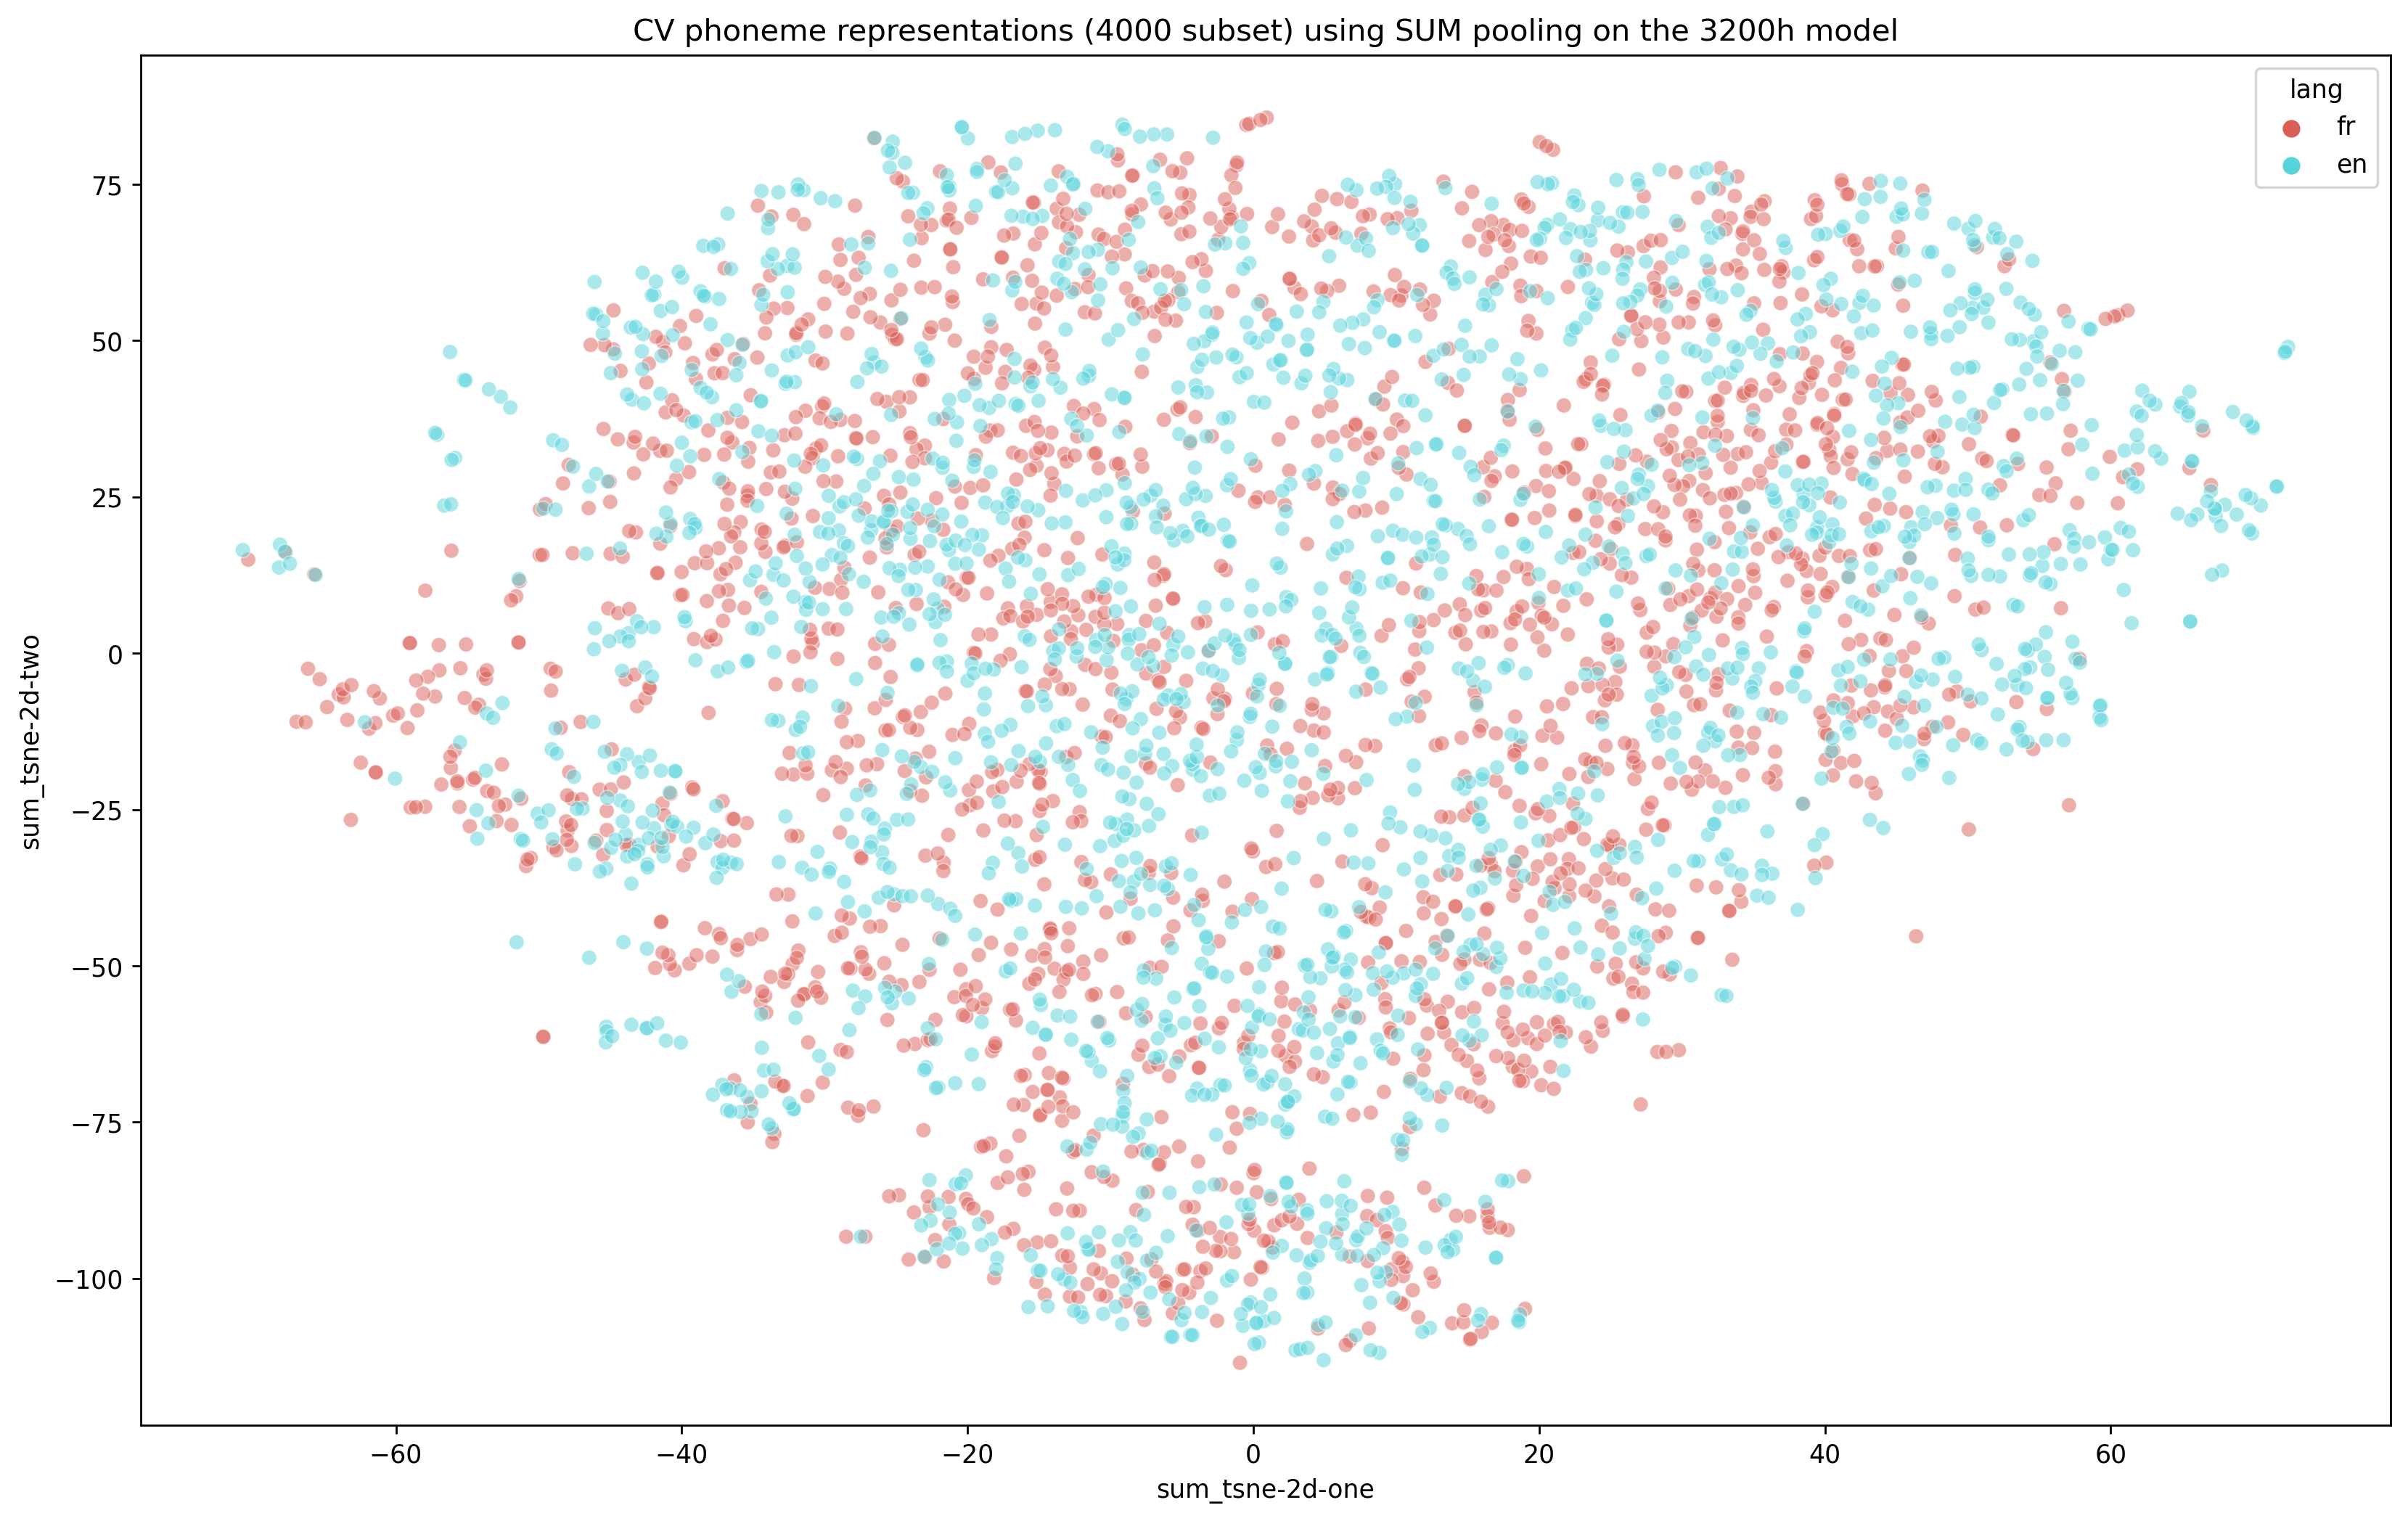

In [13]:
phone_ali_subset['sum_tsne-2d-one'] = sum_tsne_results[:,0]
phone_ali_subset['sum_tsne-2d-two'] = sum_tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="sum_tsne-2d-one", y="sum_tsne-2d-two",
    hue="lang",
    palette=sns.color_palette("hls", 2),
    data=phone_ali_subset,
    legend="full",
    alpha=0.5
)
plt.title('CV phoneme representations (4000 subset) using SUM pooling on the 3200h model')

In [14]:
phone_ali

wav  num  onset  dur_s phone_long  None phone  \
2       common_voice_fr_20306508    1   1.97   0.09       dd_B   NaN    dd   
3       common_voice_fr_20306508    1   2.06   0.12       ou_I   NaN    ou   
4       common_voice_fr_20306508    1   2.18   0.10       ei_E   NaN    ei   
5       common_voice_fr_20306508    1   2.28   0.04       ai_S   NaN    ai   
6       common_voice_fr_20306508    1   2.32   0.07       pp_B   NaN    pp   
...                          ...  ...    ...    ...        ...   ...   ...   
287888  common_voice_en_23817084    1   3.11   0.08        n_E   NaN     n   
287889  common_voice_en_23817084    1   3.19   0.08        y_B   NaN     y   
287890  common_voice_en_23817084    1   3.27   0.07       ih_I   NaN    ih   
287891  common_voice_en_23817084    1   3.34   0.08        r_I   NaN     r   
287892  common_voice_en_23817084    1   3.42   0.19        z_E   NaN     z   

        dur_ms lang                                           max_pool  \
2         90.0   fr  [0.004222347866743803, 0.023073552176356316, 0...   
3        120.0   fr  [0.11463875323534012, 0.05788165703415871, 0.2...   
4        100.0   fr  [0.32231777906417847, 0.0031087964307516813, 0...   
5         40.0   fr  [0.16016335785388947, 0.05454303324222565, 0.2...   
6         70.0   fr  [-0.02370539680123329, -0.0003782134153880179,...   
...        ...  ...                                                ...   
287888    80.0   en  [0.43508589267730713, 0.01228343602269888, 0.1...   
287889    80.0   en  [0.10142574459314346, 0.0014068669406697154, 0...   
287890    70.0   en  [0.29670724272727966, 0.0004166398721281439, 0...   
287891    80.0   en  [0.14181168377399445, 0.01815667562186718, 0.3...   
287892   190.0   en  [0.05566798523068428, 0.060646068304777145, 0....   

                                                 sum_pool  \
2       [-0.005919264745898545, -0.14476094814017415, ...   
3       [0.477940266027872, 0.27511871373280883, 2.292...   
4       [1.937747448682785, 0.012527602488262346, 2.69...   
5       [0.4276389554142952, 0.0824609960836824, 0.868...   
6       [-0.6923451013863087, -0.20613421086454764, 0....   
...                                                   ...   
287888  [0.37767017632722855, 0.04758532578125596, 0.3...   
287889  [0.1496952006709762, 0.000687403378833551, 1.8...   
287890  [0.8628647103905678, 0.0004733399618999101, 1....   
287891  [0.4877385995350778, 0.02160825624014251, 1.90...   
287892  [-0.11673597036860883, -0.05723974428838119, 1...   

                                                 avg_pool  
2       [-0.000657696082877616, -0.016084549793352682,...  
3       [0.039828355502322665, 0.02292655947773407, 0....  
4       [0.1937747448682785, 0.0012527602488262347, 0....  
5       [0.1069097388535738, 0.0206152490209206, 0.217...  
6       [-0.09890644305518695, -0.029447744409221092, ...  
...                                                   ...  
287888  [0.04720877204090357, 0.005948165722656995, 0....  
287889  [0.018711900083872024, 8.592542235419387e-05, ...  
287890  [0.12326638719865254, 6.761999455713002e-05, 0...  
287891  [0.060967324941884726, 0.0027010320300178137, ...  
287892  [-0.006143998440453096, -0.0030126181204411153...  

[524736 rows x 12 columns]

Text(0.5, 1.0, 'CV phoneme representations (4000 subset) using MAX pooling')

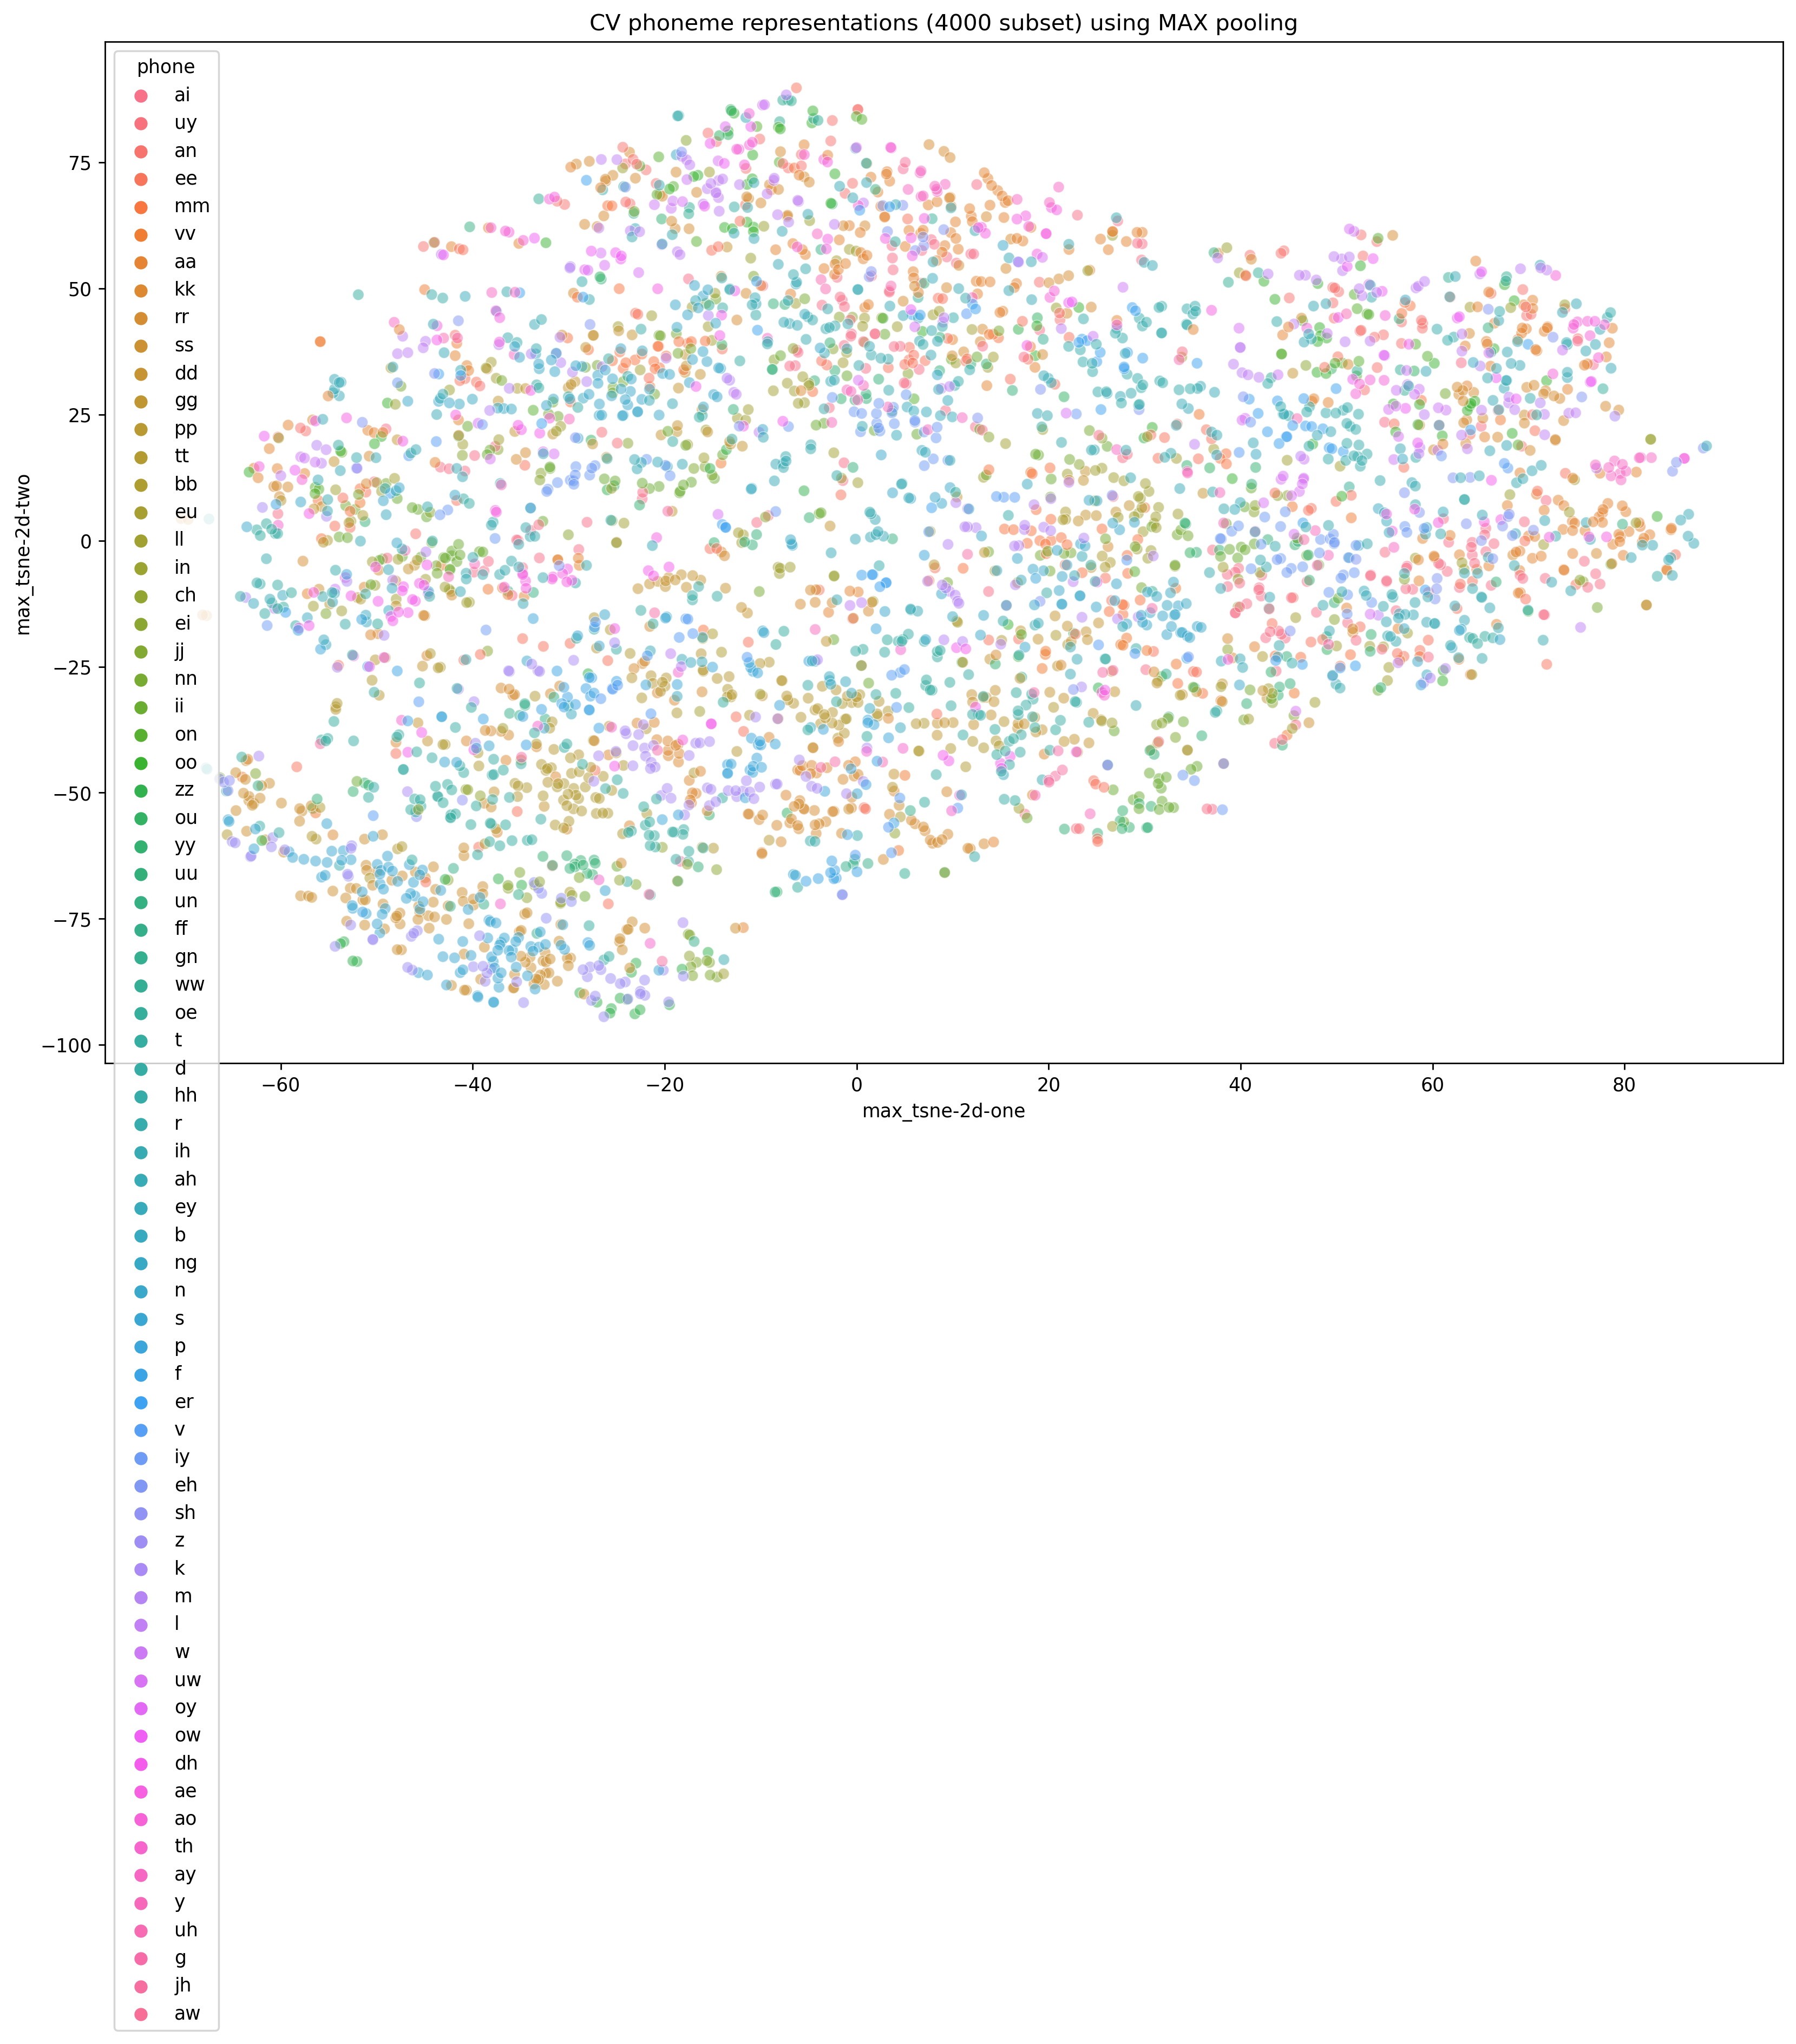

In [15]:
phone_ali_subset['max_tsne-2d-one'] = max_tsne_results[:,0]
phone_ali_subset['max_tsne-2d-two'] = max_tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="max_tsne-2d-one", y="max_tsne-2d-two",
    hue="phone",
    data=phone_ali_subset,
    legend="full",
    alpha=0.5
)
plt.title('CV phoneme representations (4000 subset) using MAX pooling')

Text(0.5, 1.0, 'CV phoneme representations (4000 subset) using MAX pooling')

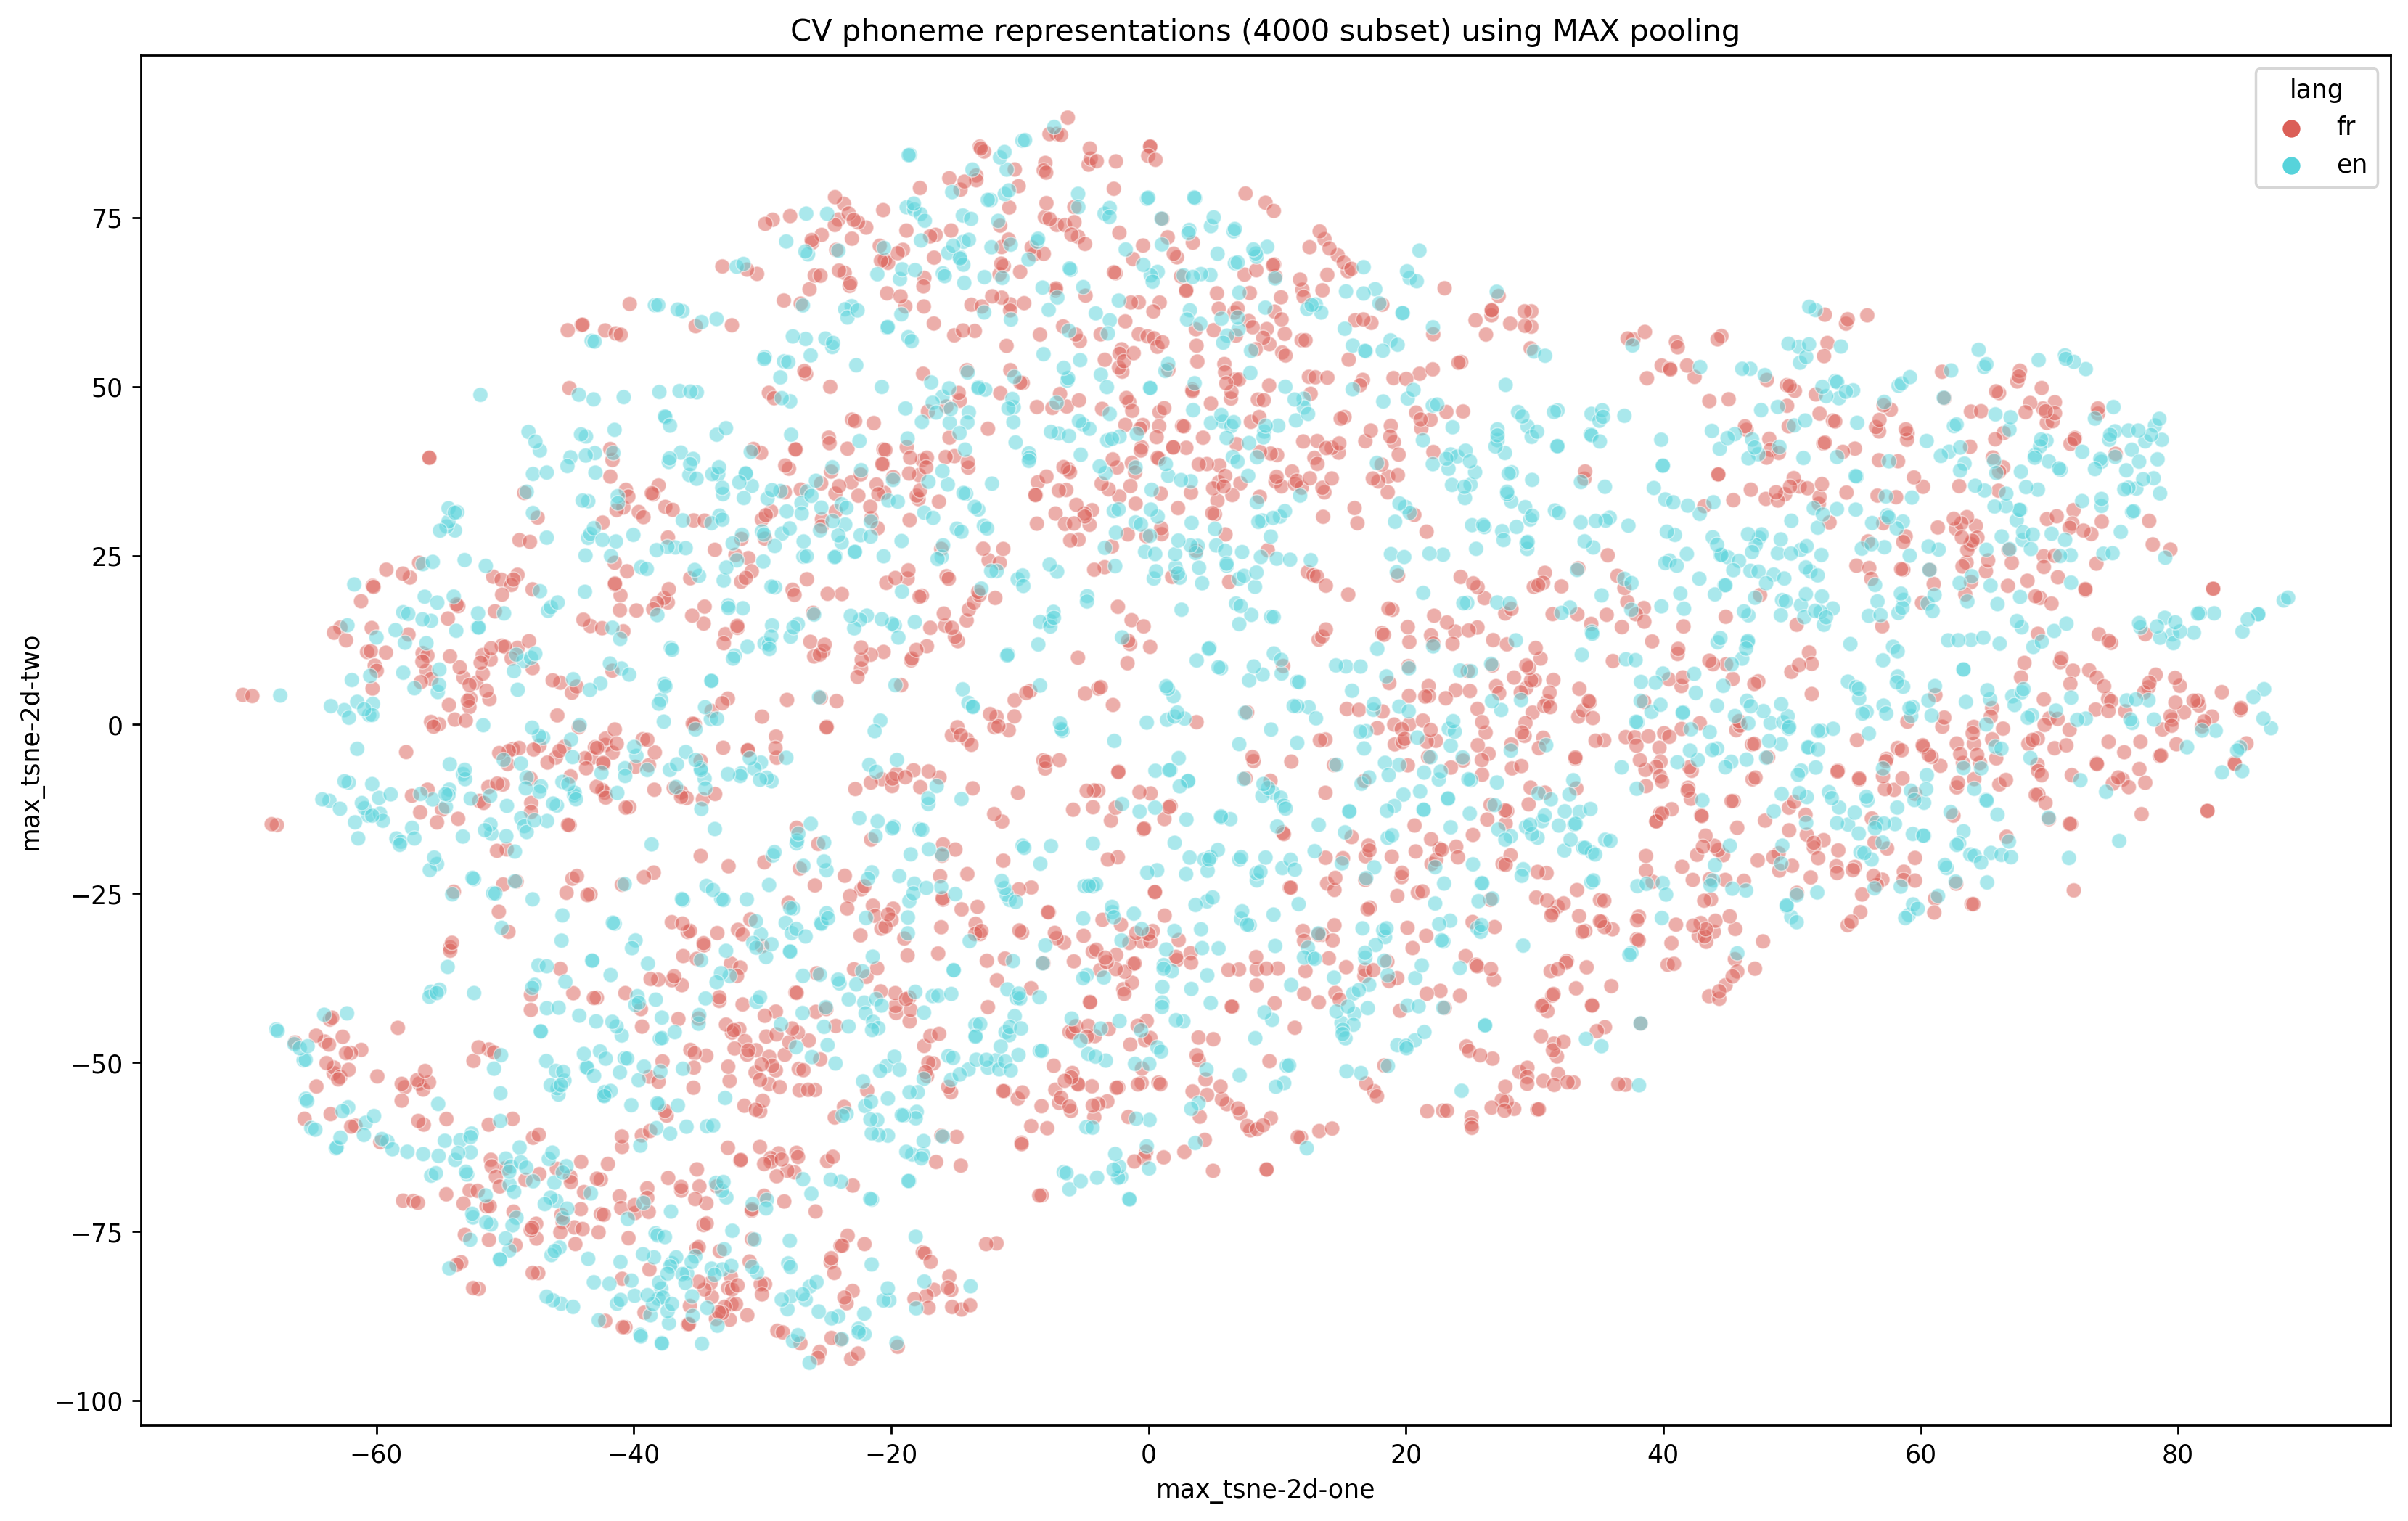

In [16]:
phone_ali_subset['max_tsne-2d-one'] = max_tsne_results[:,0]
phone_ali_subset['max_tsne-2d-two'] = max_tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="max_tsne-2d-one", y="max_tsne-2d-two",
    hue="lang",
    palette=sns.color_palette("hls", 2),
    data=phone_ali_subset,
    legend="full",
    alpha=0.5
)
plt.title('CV phoneme representations (4000 subset) using MAX pooling')

Text(0.5, 1.0, 'CV phoneme representations (4000 subset) using AVG pooling on EN MODEL')

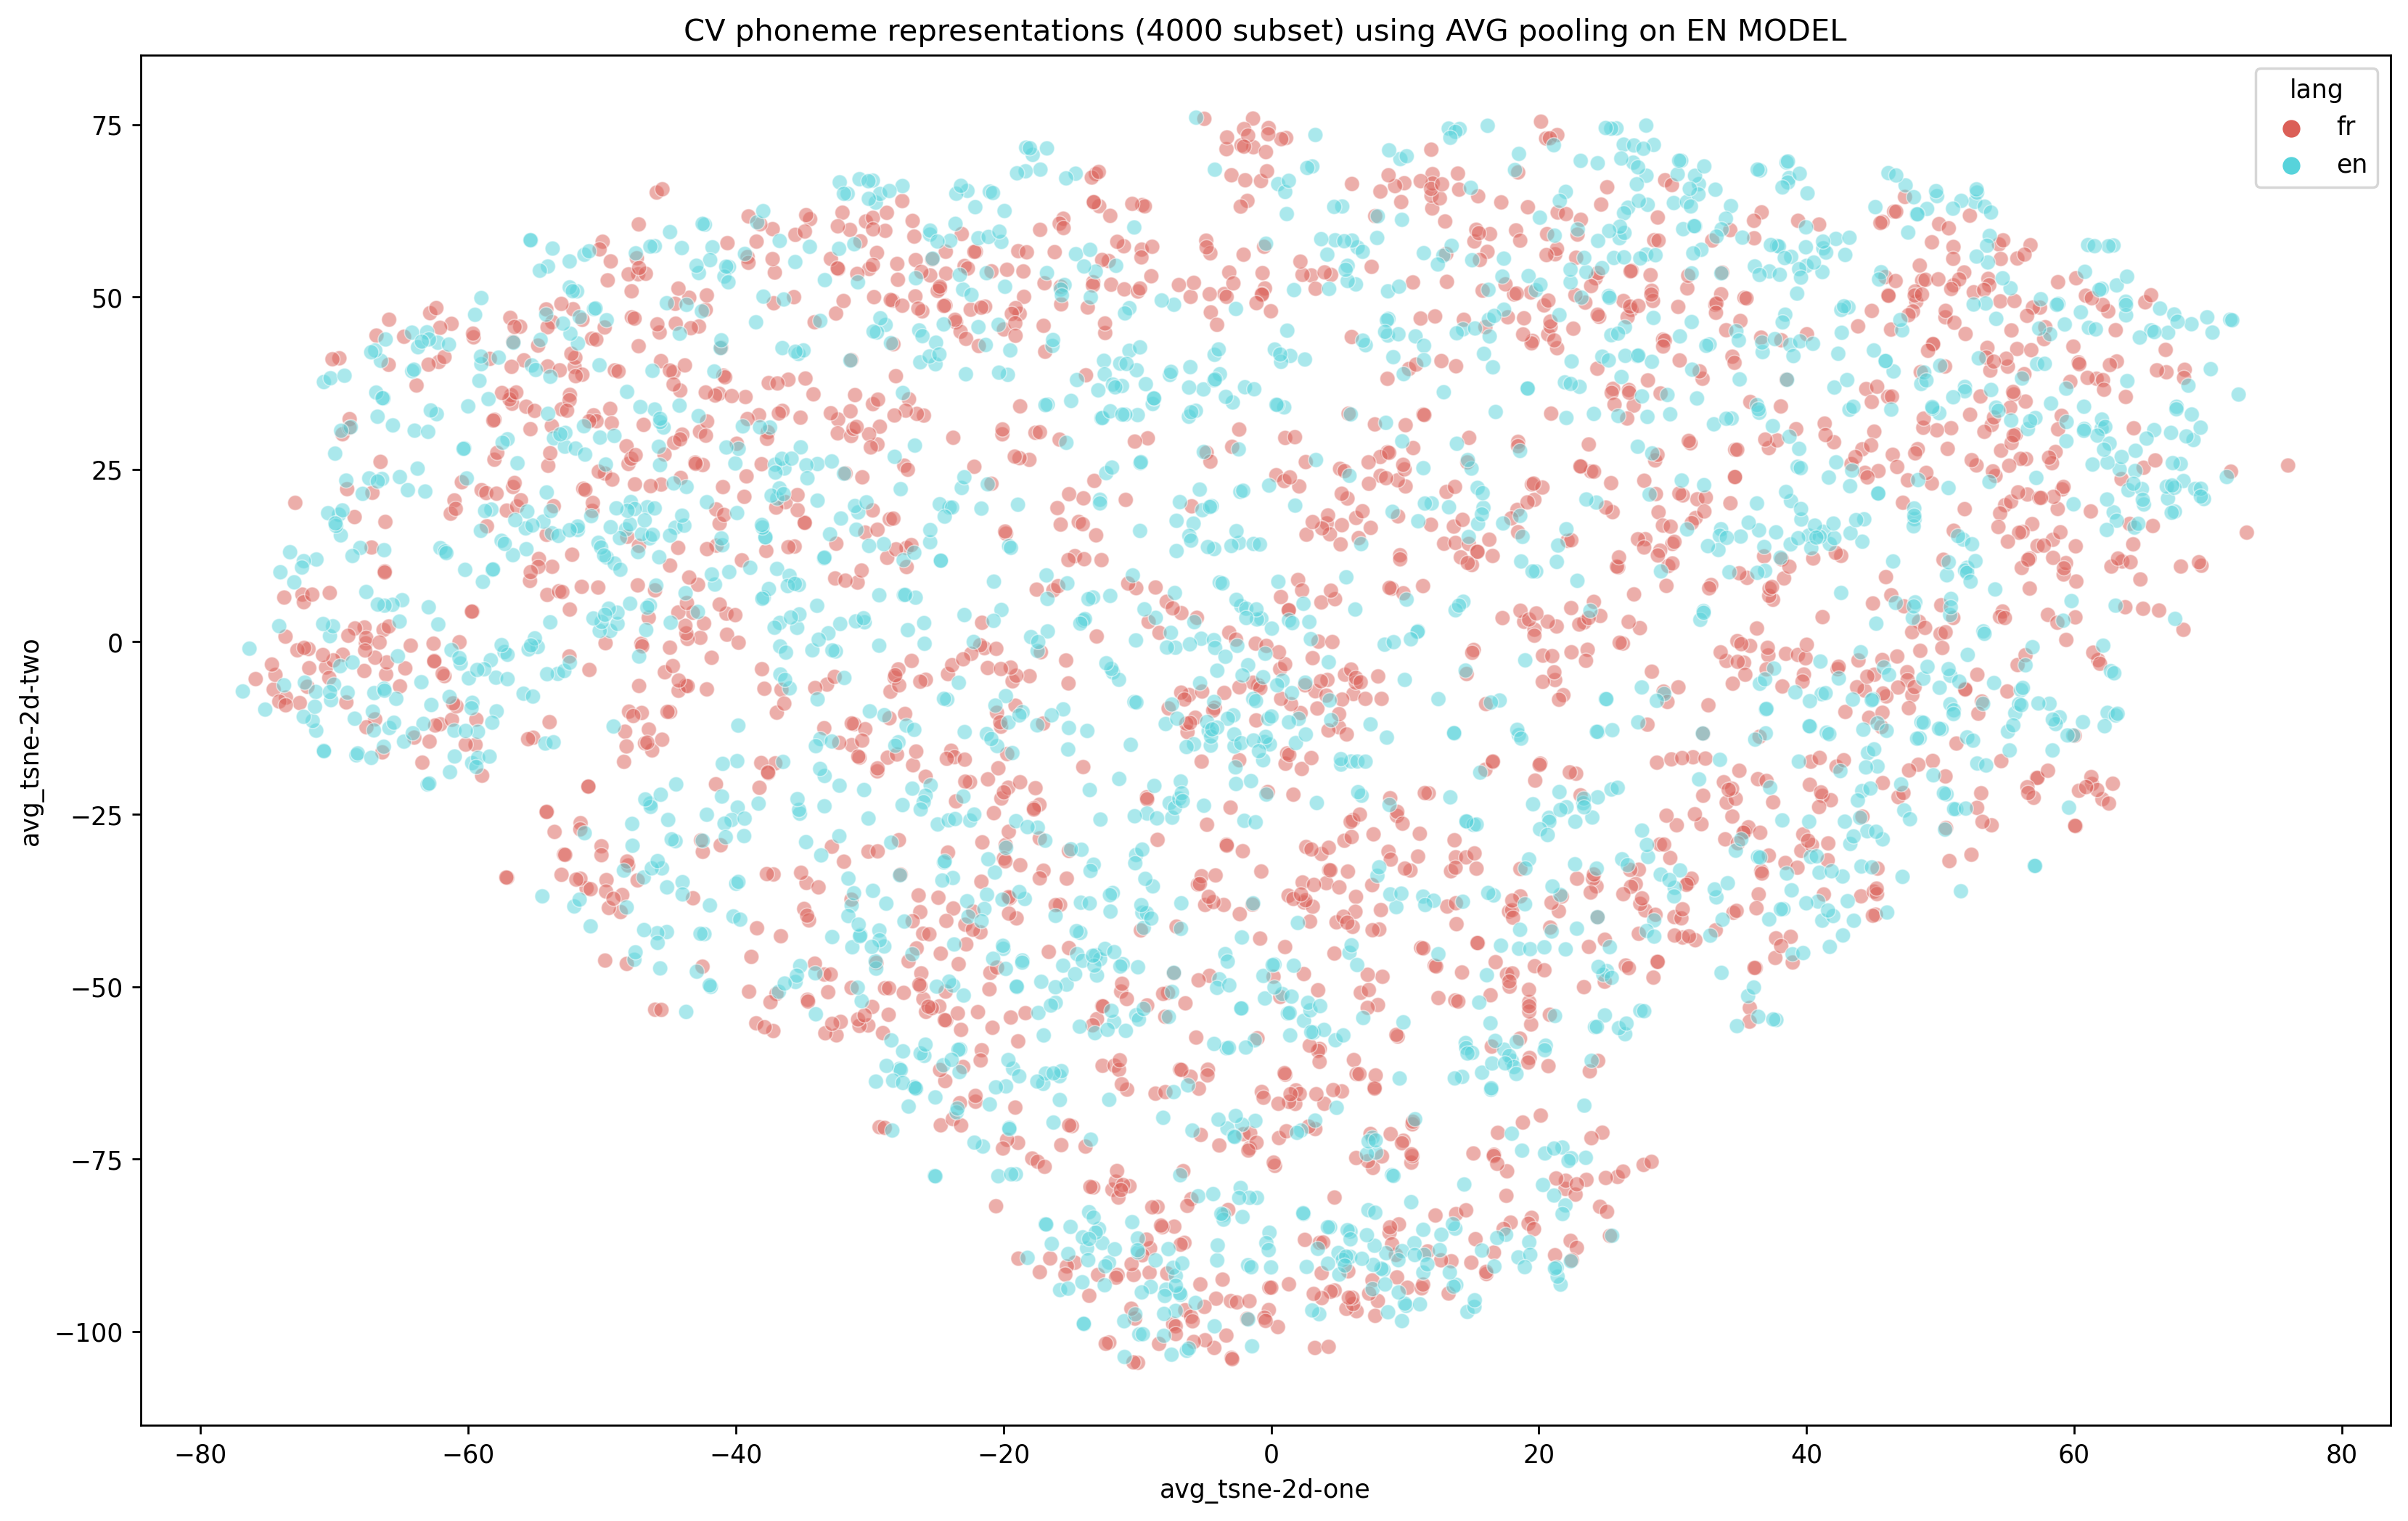

In [20]:
phone_ali_subset['avg_tsne-2d-one'] = avg_tsne_results[:,0]
phone_ali_subset['avg_tsne-2d-two'] = avg_tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="avg_tsne-2d-one", y="avg_tsne-2d-two",
    hue="lang",
    palette=sns.color_palette("hls", 2),
    data=phone_ali_subset,
    legend="full",
    alpha=0.5
)
plt.title('CV phoneme representations (4000 subset) using AVG pooling on EN MODEL')

In [18]:
en_phone_char = {
    'dh': 'plosive', 'ah':'vowel', 'v':'fricative', 'ae':'vowel', 'l':'semi-vowel', 'iy':'vowel',
    'w':'semivowel', 'z':'fricative', 'f':'fricative', 'ih':'vowel', 'd':'plosive', 'th':'fricative',
    'eh':'vowel', 'n':'nasal', 's':'fricative', 'ao':'vowel', 'g':'plosive', 'jh':'affricate', 'k':'plosive',
    'm':'nasal', 'ay':'vowel', 'er':'vowel', 'ow':'vowel', 'r':'semi-vowel', 'y':'vowel', 'uw':'vowel', 
    'hh':'fricative', 't':'plosive', 'p':'plosive', 'sh':'fricative', 'uh':'vowel', 'aa':'vowel', 'ng':'nasal', 
    'ey':'vowel', 'b':'plosive', 'aw':'plosive', 'ch':'affricate', 'oy':'vowel', 'zh':'fricative'
}

In [19]:
hours=100
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/{}h/00/features/cpc_small/'.format(hours)
lang='en'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_en = retrieve_alignment(ali_ctm, lang, root_path=root)

In [13]:
hours=100
root = '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/{}h/00/features/cpc_small/'.format(hours)
lang='fr'
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)
phone_ali_fr = retrieve_alignment(ali_ctm, lang,  root_path=root)

1. Retrieveing w2feats


FileNotFoundError: [Errno 2] No such file or directory: '/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/100h/00/features/cpc_small/CV_fr'